In [1]:
from Axion import ALP
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import stats
%matplotlib inline
import os
import blueice as bi
from blueice.inference import bestfit_scipy

/project/lgrandi/anaconda3/envs/stats/lib/python3.4/site-packages/blueice-1.0.0-py3.4.egg/blueice/inference.py:27: UserWarning: You don't have iminuit installed; switching to scipy minimizers.We've had several issues with these on degenerate problems, you're advised to do conda install -c astropy iminuit
  warnings.warn("You don't have iminuit installed; switching to scipy minimizers."


### Let's simulate some axions ###

In [2]:
mass = 5 # keV
a = ALP(mass, g=1e-13)

In [3]:
lf = bi.UnbinnedLogLikelihood(a.config)
lf.add_rate_parameter('erbkg')
lf.add_rate_parameter('ALP')
lf.prepare()

Total events: 451


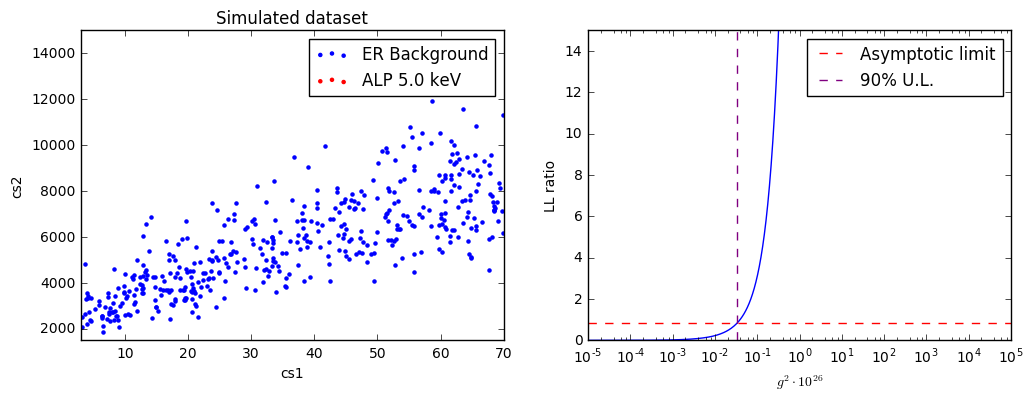

Total events: 437


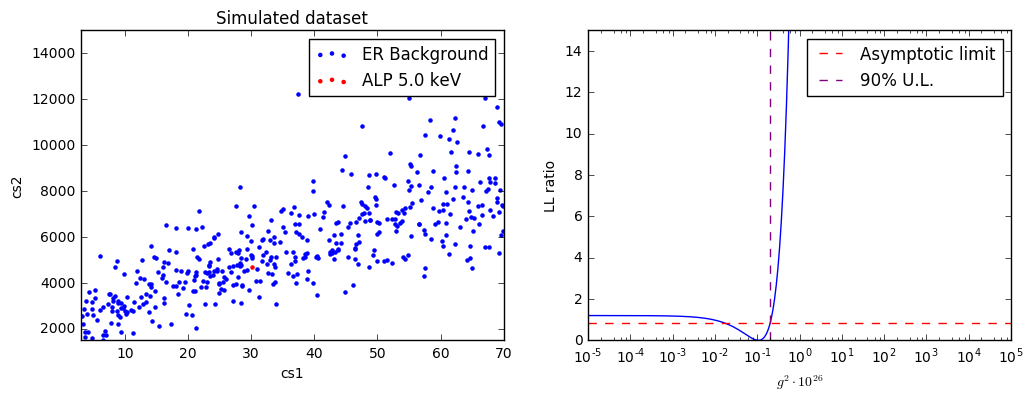

Total events: 427


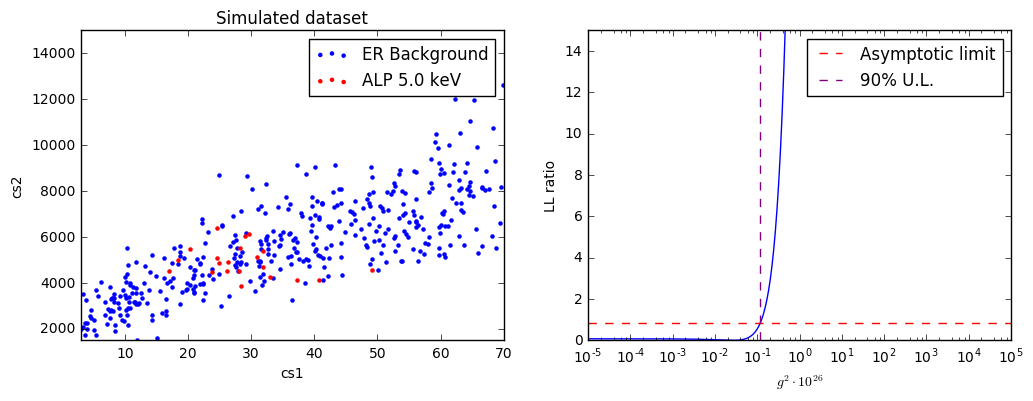

Total events: 657


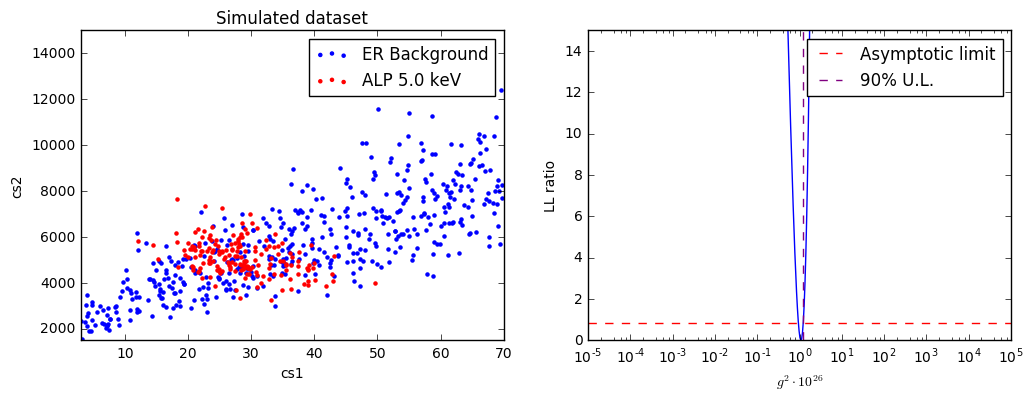

Total events: 2191


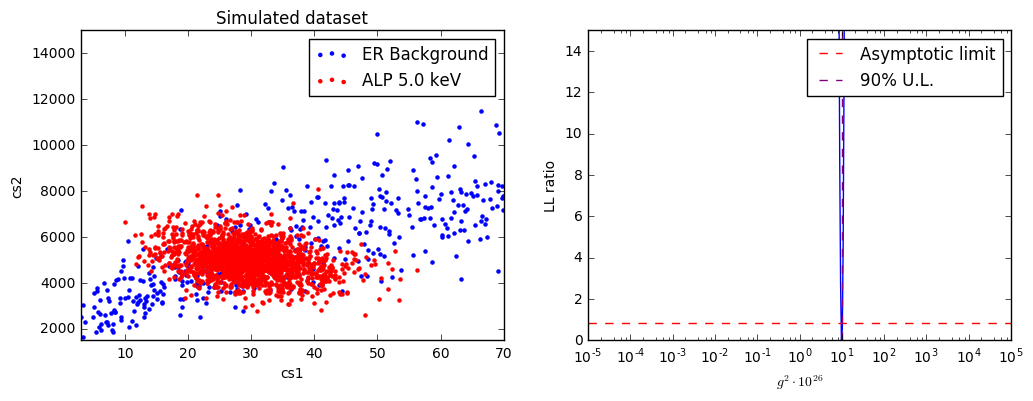

In [6]:
minimize_kwargs = {'method' : "Powell", "options" : {'maxiter' : 10000000}}

rate_mults = [0, 1e-2, 1e-1, 1, 1e1]

space_ax = ('ALP_rate_multiplier', np.logspace(-5, 5, 500))
space_er = ('erbkg_rate_multiplier', np.linspace(0, 2, 100))
label = 'LL ratio'

for i, mult in enumerate(rate_mults):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    d = lf.base_model.simulate(dict(ALP=mult, erbkg=1))
    print("Total events: %d" % len(d))
    lf.set_data(d)
    fit_result, max_ll = bi.inference.bestfit_scipy(lf, minimize_kwargs=minimize_kwargs)
    #print(fit_result)
    
    plt.sca(ax1)
    lf.base_model.show(d)
    plt.legend()
    plt.title("Simulated dataset")
    
    plt.sca(ax2)
    limit = bi.inference.one_parameter_interval(lf, 'ALP_rate_multiplier', 1e4,
                                                bestfit_routine=bestfit_scipy,
                                                minimize_kwargs=minimize_kwargs)
    bi.inference.plot_likelihood_ratio(lf, space_ax, bestfit_routine=bestfit_scipy,
                                                     minimize_kwargs=minimize_kwargs)
    plt.axhline(stats.norm.ppf(0.9)**2/2,
                label='Asymptotic limit', color='r', linestyle='--')
    plt.axvline(limit, ls='--', color='purple', label='90% U.L.')
    
    plt.xscale('log')
    plt.ylim(0,15)
    plt.xlabel('$g^2 \cdot 10^{%d}$' % int(-2*np.log10(a.g_scale)))
    plt.ylabel(label)
    plt.legend()
    
    plt.savefig("sim_%d.png" % (i+1))
    plt.show()

In [7]:
g1 = 0.1426          # pe/ph
g2 = 11.55           # pe/e
W = 13.7 * 0.001     # keV

def ces(cs1, cs2b):
    return W * (cs1/g1 + cs2b/g2)


In [9]:
mass = 7
g=5e-14
a = ALP(mass, g=g)
lf = bi.UnbinnedLogLikelihood(a.config)
lf.add_rate_parameter('erbkg')
lf.add_rate_parameter('ALP')
lf.prepare()

In [10]:
n_its = 10000
rng = (0.5,20.5)
nbins = 80
bins = np.linspace(0.5, 20.5, nbins)
avg_bkgd = np.zeros_like(bins)
avg_signal = np.zeros_like(bins)

for _ in range(n_its):
    b = lf.base_model.simulate(dict(ALP=0, erbkg=1))
    s = lf.base_model.simulate(dict(ALP=1, erbkg=1))

    # 0.6 hardcoded to make energies match up
    # think this is due to cs2 vs cs2_bottom? Not sure
    b_ces = 0.6*ces(b['cs1'], b['cs2'])
    s_ces = 0.6*ces(s['cs1'], s['cs2'])
    
    bhist, bins = np.histogram(b_ces, range=rng, bins=nbins)
    shist, _ = np.histogram(s_ces, range=rng, bins=nbins)
    
    avg_bkgd += bhist
    avg_signal += shist

avg_bkgd /= n_its
avg_signal /= n_its

bins = 0.5*(bins[1:]+bins[:-1])

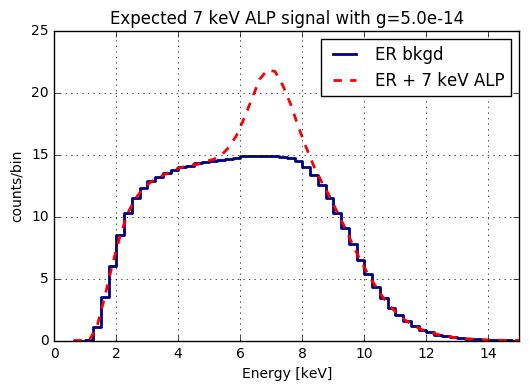

In [11]:
plt.plot(bins, avg_bkgd, drawstyle='steps-mid', color='navy', label='ER bkgd', linewidth=2)
plt.plot(bins, avg_signal, color='red', linestyle='--', label='ER + %d keV ALP' % mass, linewidth=2)
plt.xlim(0,15)
plt.xlabel('Energy [keV]')
plt.ylabel('counts/bin')
plt.title('Expected %d keV ALP signal with g=%0.1e' %(mass, g))
plt.legend()
plt.grid()
plt.savefig('ALP_ces.pdf')
plt.show()

In [12]:
import pandas as pd


# read in data
sr0 = pd.read_csv('data/data_none_lowenergy_roi.csv')
sr1_file = '/project/lgrandi/xenon1t/data/180305/all_cuts/none_SR1_pax6.8.0_hax2.4.0_lax1.5.1_cs1LT200_fv1_cuts1.h5'
sr1 = pd.read_hdf(sr1_file, 'table')


Opening /project/lgrandi/xenon1t/data/180305/all_cuts/none_SR1_pax6.8.0_hax2.4.0_lax1.5.1_cs1LT200_fv1_cuts1.h5 in read-only mode


In [13]:
# make cuts so we use same analysis space

analysis_space = {var: space for var, space in a.config['analysis_space']}


for var in ['cs1', 'cs2']:
    sr1 = sr1[sr1.apply(lambda x: min(analysis_space[var]) <= x[var] <= max(analysis_space[var]), axis=1)]


561 SR1 ER events


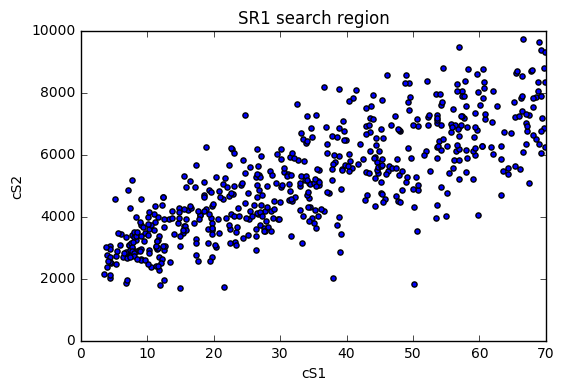

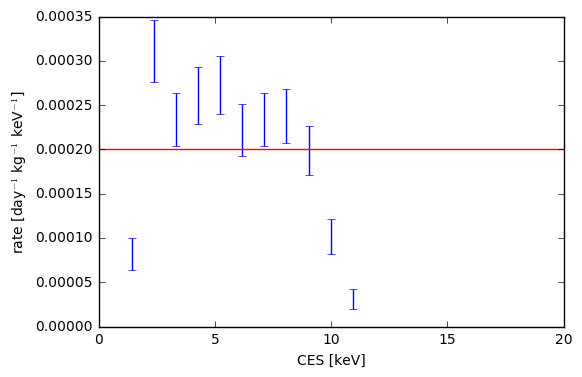

In [14]:
g1 = 0.1426   # pe/ph
g2 = 11.55    # pe/e
W = 13.7      # eV

def ces(cs1, cs2b):
    return W * (cs1/g1 + cs2b/g2)

print('%d SR1 ER events' % len(sr1.index))
plt.scatter(sr1['cs1'], sr1['cs2'], s=14)
plt.title("SR1 search region")
plt.xlabel("cS1")
plt.ylabel("cS2")
plt.ylim(0,10000)
plt.xlim(0,70)
plt.savefig("sr1_data.png")
plt.show()

sr1['ces'] = sr1.apply(lambda x: ces(x['cs1'], x['cs2_bottom'])/1000, axis=1)
hist, bins = np.histogram(sr1['ces'], bins=20, range=(0,19))
hist_err = np.sqrt(hist)
# normalize by exposure
hist = hist / a.config['livetime_days'] / a.config['fiducial_mass']
hist_err = hist_err / a.config['livetime_days'] / a.config['fiducial_mass']
bins = 0.5*(bins[:-1] + bins[1:])
plt.errorbar(bins, hist, yerr=hist_err, linestyle='None')
plt.ylabel('rate [day$^{-1}$ kg$^{-1}$ keV$^{-1}$]')
plt.xlabel('CES [keV]')
plt.axhline(0.0002, color='red')
plt.show()

In [15]:
# write the ER background file

erbg_Erange = (1e-9, 15.0)
erbg_nbins = 1000
E_bins = np.linspace(erbg_Erange[0], erbg_Erange[1], erbg_nbins)
rate_per_bin = np.ones(len(E_bins))*0.0002

with open("data/er_bg.csv", "w") as f:
    f.write(",kev,events_per_day\n")
    for i, (E, r) in enumerate(zip(E_bins, rate_per_bin)):
        f.write("%d,%g,%g\n" % (i, E, r))    

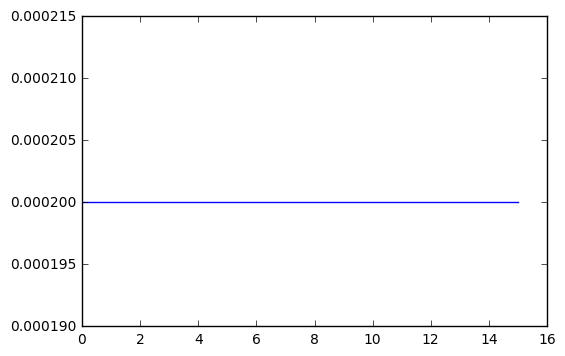

In [16]:
# plot ER_shape
erbg = pd.read_csv('data/er_bg.csv')
plt.plot(erbg['kev'], erbg['events_per_day'])


In [17]:
masses = np.linspace(1,12,100) # keV

In [18]:
def cleanup():
    # clean up the data directories
    for d in ['likelihood_plots', 'limit_data']:
        for file in os.listdir(d):
            os.remove("%s/%s" % (d, file))
cleanup()

In [19]:
from batchq import submit_job
import os
from tqdm import tqdm 
import time


jobtemplate = """cd ~/scratch2
mkdir tmp_{file_counter}
cd tmp_{file_counter}
source activate stats
python /home/ershockley/analysis/axions/axionlimit.py {axion_type} {mass} {file_counter}

cd ..
rm -r tmp_{file_counter}
"""

axion_type = 'ALP'

# counter used for naming files
for counter, m in enumerate(tqdm(masses)): # enumerate(masses): 
    fc_str = str(counter).zfill(3)
    lim_file = "limit_data/ALP_limit_%s.txt" % fc_str
    if os.path.exists(lim_file):
        continue
    jobname = "axion_%d" % counter
    log = 'logs/%s.log' % jobname
    job_string = jobtemplate.format(axion_type=axion_type,
                                    mass=m,
                                    file_counter=counter)
    submit_job(job_string, log=log, jobname=jobname, partition='broadwl', qos='broadwl')
    time.sleep(1)
    #break

##############################################

from subprocess import Popen, PIPE
import time

def jobs_running():
    output = Popen(["squeue","--user", "ershockley"], stdin=PIPE, stdout=PIPE, stderr=PIPE).stdout.read()
    output = output.decode("utf-8").split("\n")
    jobs = len([l for l in output if 'axion' in l])
    return (jobs > 0)

# wait for jobs to finish
print("waiting for jobs to finish")
while jobs_running():
    print("..", end='')
    time.sleep(30)
print("\nDONE")

100%|██████████| 100/100 [02:45<00:00,  1.07s/it]


waiting for jobs to finish
........................................................
DONE


FIGURE 3a


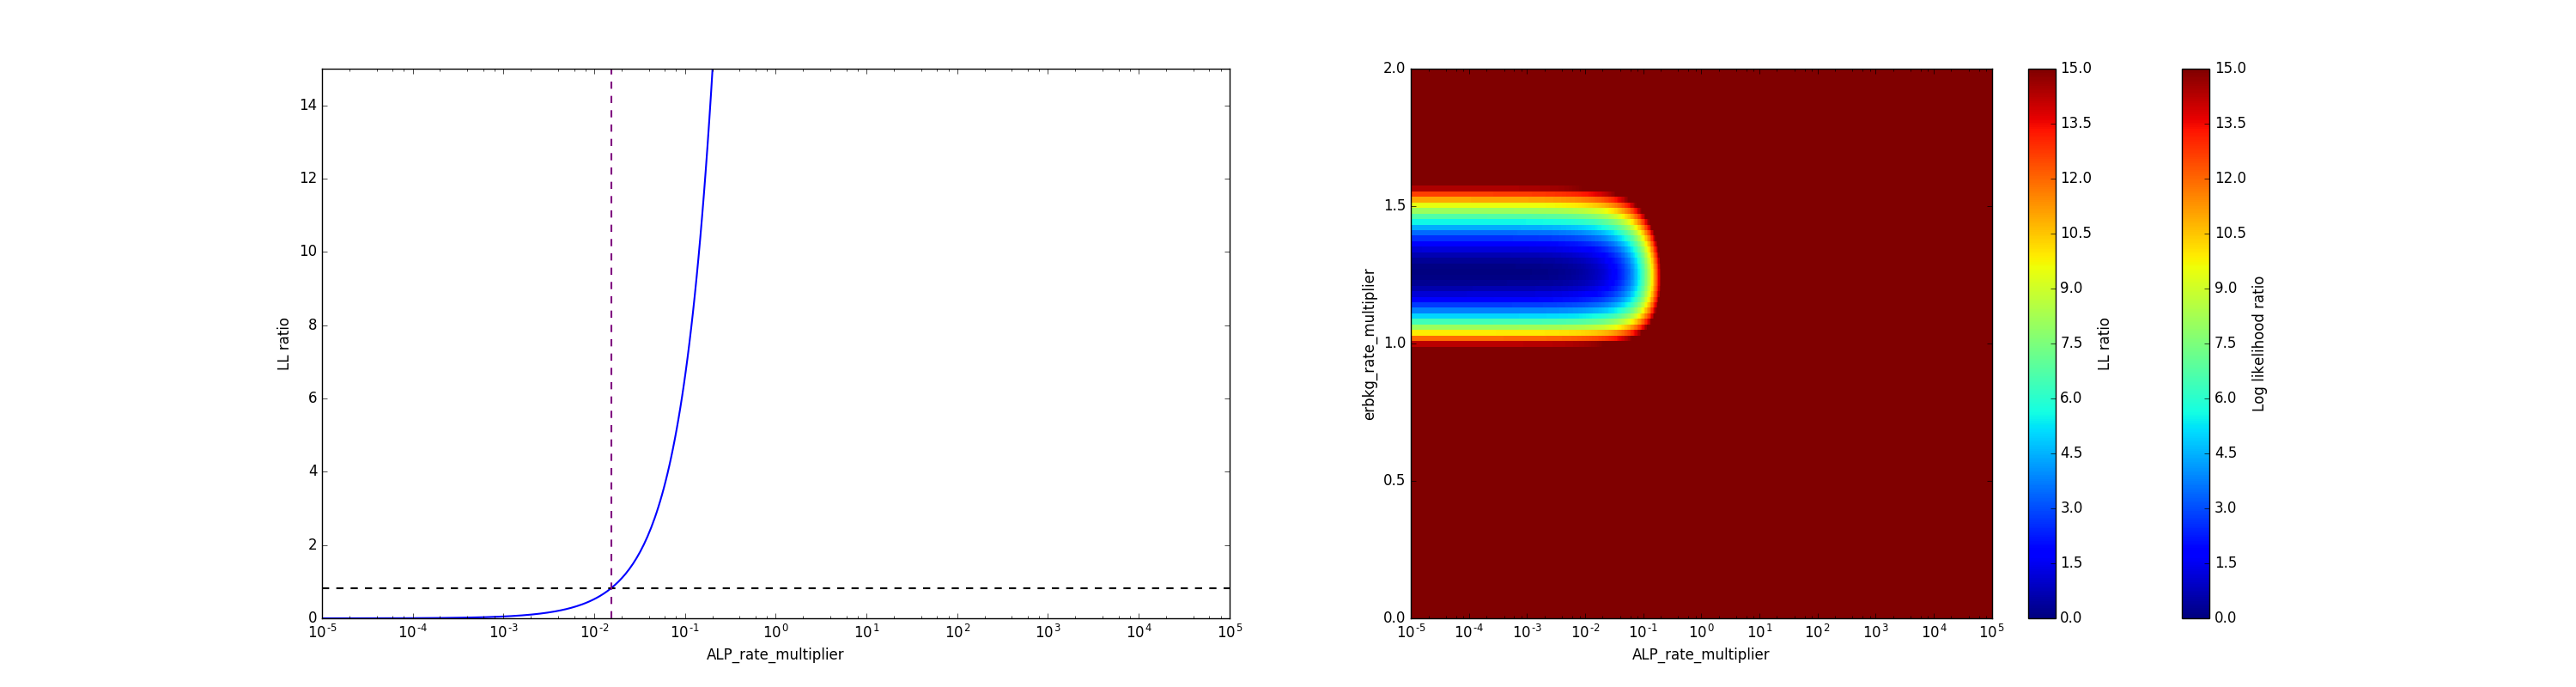

FIGURE 3b


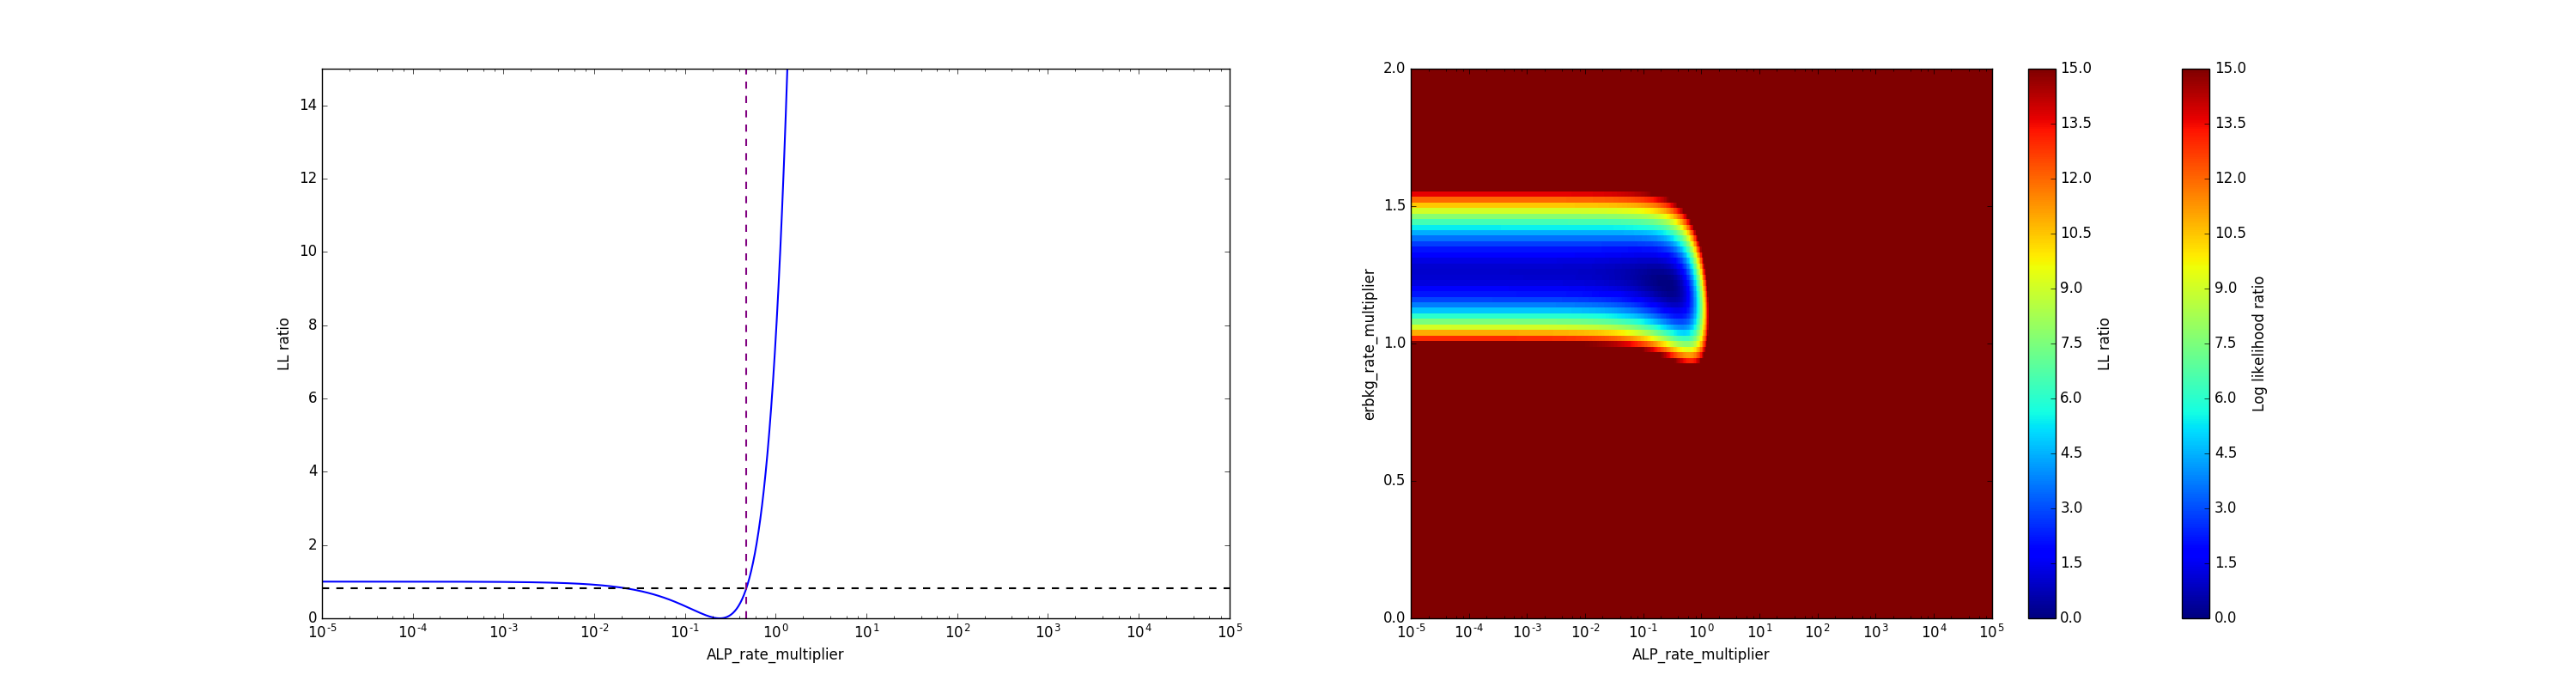

FIGURE 3c


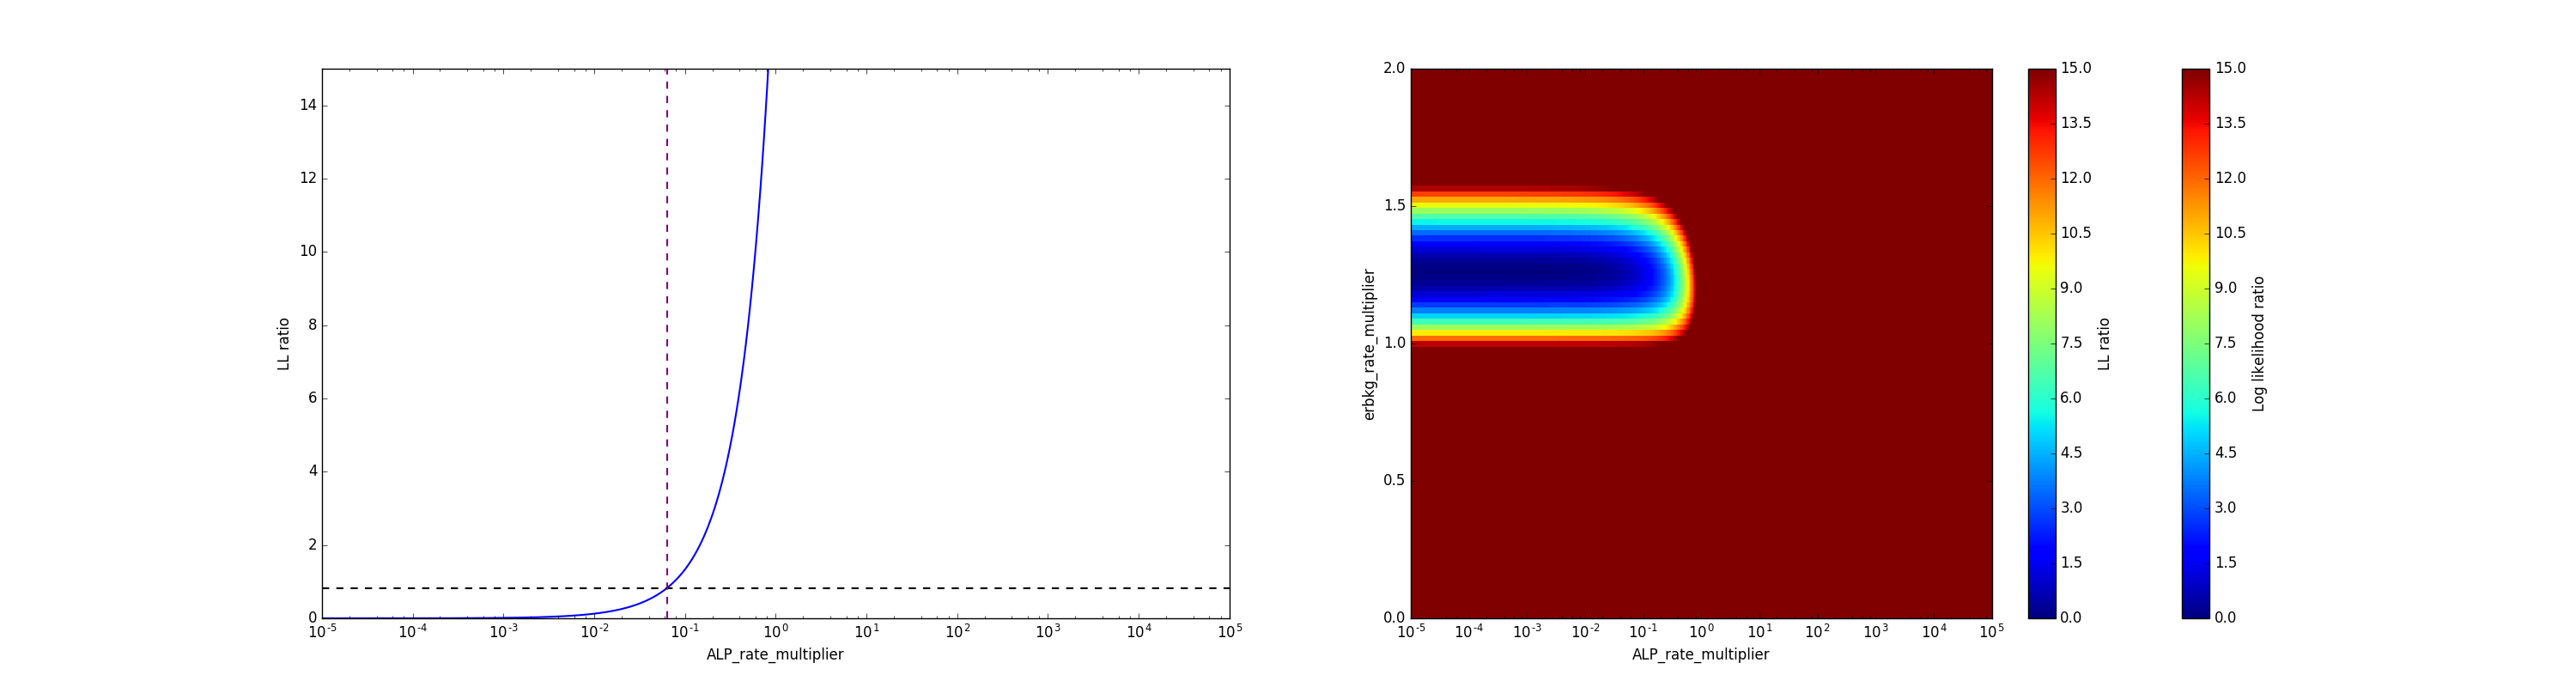

In [20]:
from IPython.display import Image, display
axion_type='ALP'
labels='abcdefghijklmnopqrstuvwxyz'

for i, num in enumerate([2, 30, 80]):
    print("FIGURE 3%s" % labels[i])
    s = str(num).zfill(3)
    display(Image("likelihood_plots/%s_likelihood_%s.png" % (axion_type, s), width=1000, height=800))

In [21]:
from scipy import stats

def sens_band(filename, mass):
    limits = []
    with open(filename) as f:
        for num, line in enumerate(f):
            if num==0:
                mass_from_file = float(line.split(":")[1])
                assert abs(mass_from_file - mass) < 1e-6
            else:
                limits.append(float(line))
    
    med = np.sqrt(np.median(limits)) * ALP.g_scale
    lower1 = np.sqrt(np.percentile(limits, stats.norm.cdf(-1)*100)) * ALP.g_scale
    upper1 = np.sqrt(np.percentile(limits, stats.norm.cdf(1)*100)) * ALP.g_scale
    lower2 = np.sqrt(np.percentile(limits, stats.norm.cdf(-2)*100)) * ALP.g_scale
    upper2 = np.sqrt(np.percentile(limits, stats.norm.cdf(2)*100)) * ALP.g_scale
    
    return dict(median=med, lower1=lower1, upper1=upper1, lower2=lower2, upper2=upper2)

In [22]:
import pandas as pd
band = {"median" : [],
        "upper1" : [],
        "lower1" : [],
        "upper2" : [],
        "lower2" : []}
LIMIT = []
LIMIT2 = []
LIMIT03 = []
ER_fits = []
plot_masses = []
wilks_check = []
wilks_errs = []
bestfit = []
pvalues = []

for num, mass in enumerate(masses):
    fc_str = str(num).zfill(3)
    lim_file = "limit_data/ALP_limit_%s.txt" % fc_str
    #lim_file03 = "limit_data_03/ALP_limit_%s.txt" % fc_str
    if os.path.exists(lim_file):
        data = pd.read_csv(lim_file)
        #data03 = pd.read_csv(lim_file03)
        assert abs(data['mass'].values[0] - mass) < 1e-2
        lim = data['glimit'].values[0]
        #lim03 = data03['glimit'].values[0]
        LIMIT.append(lim)
        #LIMIT03.append(lim03)
        ER_fits.append(data['er_best'].values[0])
        plot_masses.append(mass)
        bestfit.append(data['axion_best'])
        pvalues.append(data['pvalue'])
    
        # sensitivity
        sens_file = "limit_data/ALP_sensitivity_%s.txt" % fc_str
        thisband = sens_band(sens_file, mass)
        for key in band:
            band[key].append(thisband[key])
    else:
        print("Data for mass %0.2f (number %d) not found" % (mass, num))
    

In [23]:
# power constraint
#from scipy.interpolate import interp1d
 
#for i, point in enumerate(LIMIT):
#    if point <= band['lower1'][i]:
#        LIMIT[i] = band['lower1'][i]

In [24]:
xe100_lim = pd.read_csv("data/xe100limit.csv", sep="\t")
lux_lim = pd.read_csv("data/lux2013.csv", sep="\t")

In [25]:
# poisson limit
from scipy.interpolate import interp1d
A = 131.3

exposure = a.config['livetime_days'] * a.config['fiducial_mass']

xsec_data = pd.read_csv('data/photoelectric_xsecs.csv', header=0, names=["energy", "xsec"])
# energy in keV, cross section in barns/atom
xsec_interp = interp1d(xsec_data['energy'], xsec_data['xsec'])

def poisson_UL(N_measured, CL):
    """
    solve for n_upper such that prob of measuring N_measured is alpha
    """
    alpha = 1 - CL
    lambdas = np.linspace(N_measured, max(N_measured*2, 10), int(1e5))
    cdfs = stats.poisson.cdf(N_measured, lambdas)
    return lambdas[np.where(cdfs - alpha >= 0)[0][-1]]

def gaussian_UL(N_measured, CL):
    """
    This is for using the gaussian limit of the poisson distribution. It assumes the 
    standard deviation is sqrt(N)
    """
    z = norm.ppf(1-CL)
    return (0.5*(-z + np.sqrt(z**2 + 4*N_measured)))**2

def axion_rate(ma, g):
    return (1.29e19/A) * g**2 * ma * xsec_interp(ma)

def glimit(N_UL, ma):
    return np.sqrt(N_UL * A / 1.29E19 / ma / exposure / xsec_interp(ma))


N = len(sr1)
N_UL = poisson_UL(N, 0.9)
poisson_limit = np.zeros_like(plot_masses)
for i,m in enumerate(plot_masses):
    poisson_limit[i] = glimit(N_UL, m)

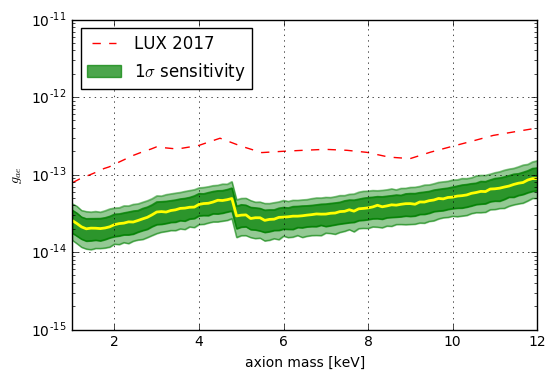

In [26]:
alpha = 0.7
fac = 0.6

fig, ax1 = plt.subplots()

ax1.plot(plot_masses, band['median'], color = 'yellow', linewidth=2, zorder=2)
ax1.plot(plot_masses, band['upper1'], color = 'green', alpha = alpha, zorder=2)
ax1.plot(plot_masses, band['lower1'], color = 'green', alpha = alpha, zorder=2)
ax1.plot(plot_masses, band['upper2'], color = 'green', alpha = fac*alpha, zorder=2)
ax1.plot(plot_masses, band['lower2'], color = 'green', alpha = fac*alpha, zorder=2)
ax1.fill_between(plot_masses, band['lower2'], band['upper2'], color='green', alpha = fac*alpha, zorder=2)
ax1.fill_between(plot_masses, band['lower1'], band['upper1'], color='green', alpha=alpha, zorder=2, 
                 label='1$\sigma$ sensitivity')
ax1.plot(lux_lim['x'], lux_lim['y'], linestyle = 'dashed', color='r', label = 'LUX 2017')
ax1.set_yscale('log')
ax1.set_xlim([1, 12])
ax1.set_ylim([1e-15, 1e-11])
ax1.set_xlabel('axion mass [keV]')
ax1.set_ylabel('$g_{ae}$')


#fig.title('ALP limit')
ax1.legend(loc='upper left')
ax1.grid(zorder=0.1)
plt.savefig('ALP_sensitivity_sr1.png')
plt.savefig('ALP_sensitivity_sr1.pdf')
plt.show()

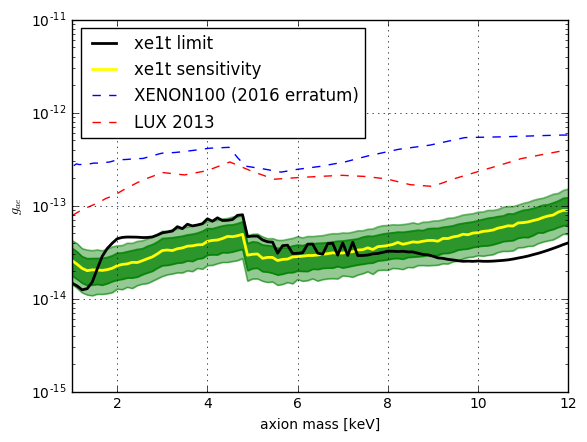

In [27]:
alpha = 0.7
fac = 0.6
#smooth_limit = medfilt(limit)
fig, ax1 = plt.subplots(figsize = (6.4,4.8))
ax1.plot(plot_masses, LIMIT, color = 'black', linewidth=2, label="xe1t limit", zorder=5)
#ax1.plot(plot_masses, LIMIT, color = 'gray', linewidth=2, label="xe1t limit 0.4GeV/cm$^3$")
#ax1.plot(plot_masses, LIMIT2, color = 'white', linewidth=2, label="xe1t_limit")
#ax1.plot(masses, poisson_limit, color = 'magenta', linewidth=2, label="xe1t poisson limit", linestyle='dashed')
#plt.plot(masses, smooth_limit, color = 'black', linewidth=2)

ax1.plot(plot_masses, band['median'], color = 'yellow', linewidth=2, label="xe1t sensitivity", zorder=2)
ax1.plot(plot_masses, band['upper1'], color = 'green', alpha = alpha, zorder=2)
ax1.plot(plot_masses, band['lower1'], color = 'green', alpha = alpha, zorder=2)
ax1.plot(plot_masses, band['upper2'], color = 'green', alpha = fac*alpha, zorder=2)
ax1.plot(plot_masses, band['lower2'], color = 'green', alpha = fac*alpha, zorder=2)
ax1.fill_between(plot_masses, band['lower2'], band['upper2'], color='green', alpha = fac*alpha, zorder=2)
ax1.fill_between(plot_masses, band['lower1'], band['upper1'], color='green', alpha=alpha, zorder=2)
ax1.plot(xe100_lim['x'], xe100_lim['y'], linestyle = 'dashed', color='b', label = 'XENON100 (2016 erratum)')
ax1.plot(lux_lim['x'], lux_lim['y'], linestyle = 'dashed', color='r', label = 'LUX 2013')
ax1.set_yscale('log')
ax1.set_xlim([1, 12])
ax1.set_ylim([1e-15, 1e-11])
ax1.set_xlabel('axion mass [keV]')
ax1.set_ylabel('$g_{ae}$')


#fig.title('ALP limit')
ax1.legend(loc='upper left')
ax1.grid(zorder=0.1)
plt.savefig('axion_limit_sr1.png')
plt.savefig('axion_limit_sr1.pdf')
plt.show()

In [28]:
def significance(p):
    return stats.norm.ppf(1-p)

def pval(signif):
    return 1 - stats.norm.cdf(signif)


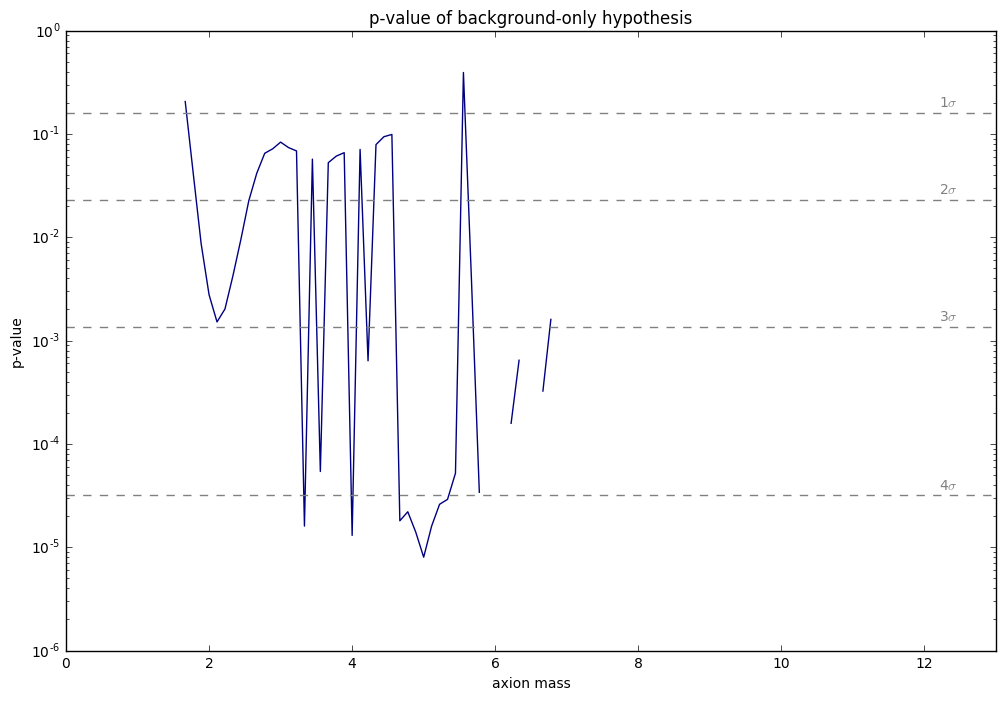

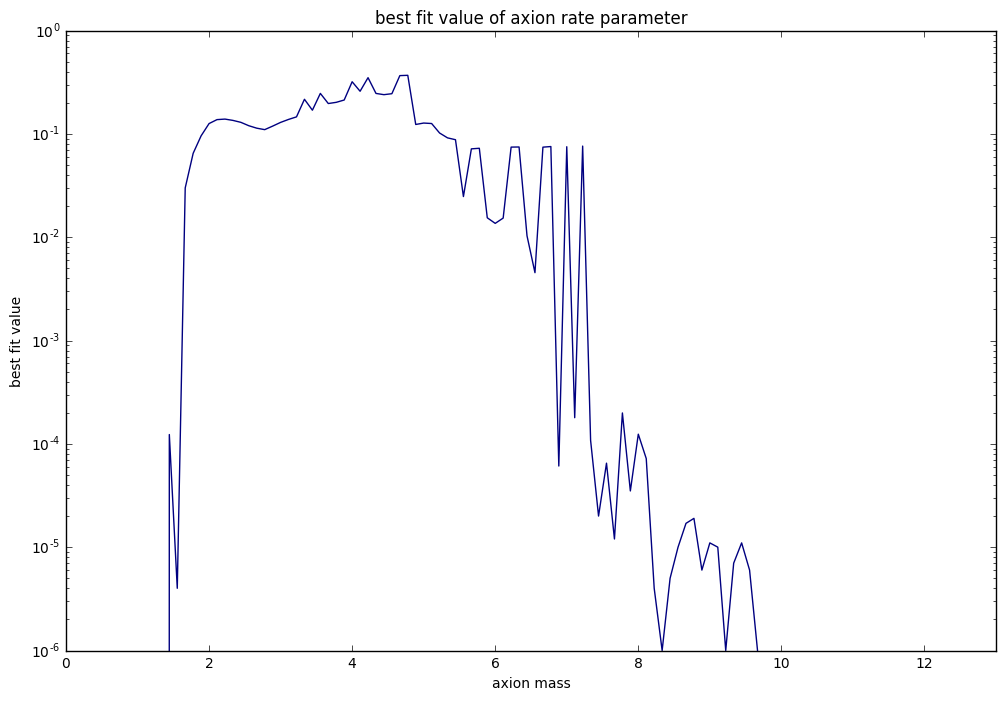

In [29]:
# pvalues

sigmas = [1,2,3,4]

plt.figure(figsize=(12,8))
plt.plot(plot_masses, pvalues, color='navy')
for sig in sigmas:
    line = pval(sig)
    plt.axhline(line, linestyle='dashed', color='gray')
    plt.text(12.2, 1.15*line, '%d$\sigma$' % sig, color ='gray')
    
plt.yscale('log')
plt.ylabel('p-value')
plt.xlabel('axion mass')
plt.title('p-value of background-only hypothesis')
plt.xlim(0,13)
plt.savefig('pvalue.pdf')
plt.show()
plt.figure(figsize=(12,8))
plt.plot(plot_masses, bestfit, color='navy')
plt.title('best fit value of axion rate parameter')
plt.xlabel('axion mass')
plt.ylabel('best fit value')
plt.xlim(0,13)
plt.savefig('bestfit.pdf')
plt.yscale('log')
plt.savefig('bestfit_log.pdf')
plt.show()



In [30]:
# find expected number of events

In [31]:
mass = 2 # keV
index = np.where(abs(masses-mass) == min(abs(masses-mass)))[0][0]
print(index)
g = LIMIT[index]

a = ALP(mass, g=g)
print('axion events: %0.3f' %  a.total_events())

9
axion events: 44.754


In [32]:
# legacy code, but don't want to delete yet 

def bootstrap_percentile_error(q, pct, bootstrap_trials=200):
    return np.std([np.percentile(np.random.choice(q, len(q)), pct) for _ in range(bootstrap_trials)])

percentiles = [50, 60, 70, 80, 85, 87.5, 90, 92.5]
for i, pct in enumerate(tqdm(reversed(percentiles))):
    plt.errorbar(np.sqrt(np.array(sorted(ts.keys()))) * 1e-13, 
                 [np.percentile(q, pct) for _, q in sorted(ts.items())],
                 yerr=[bootstrap_percentile_error(q, pct) for _, q in sorted(ts.items())],
     
                 label='%0.1f%%' % pct,
                 marker='o', linestyle='-')
plt.xscale('log')
plt.axhline(stats.norm.ppf(0.9)**2, linestyle='--', color='gray', label="Wilks' 90%")
plt.axvline(2.019680e-14, linestyle='--', color='gray', label="upper limit")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, frameon=False)
plt.xlabel("Axion coupling")
plt.ylabel("t at true rate")
plt.ylim(0, 2.5)
plt.show()

0it [00:00, ?it/s]


NameError: name 'ts' is not defined